# Investigating Information about Wellesley Professors

Author: Andrea Mock

The website of the Provost & Dean of the College contains a page which includes the current faculty roster. For each faculty member, it lists their name, title and education. Using this data we want to learn more about the makeup of the faculty pool. 

This Jupyter Notebook is broken down in the following sections:
1. Scraping faculty information 
2. Exploring faculty education history
3. Extracting department information
4. Visualizing faculty data
5. Exploring departments further

In [2]:
import pandas as pd
from collections import Counter

# import for plotting later
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

## 1. Scraping faculty data

Using Selenium, we can grab the information on the faculty roster page of the Wellesley College page. With the help of the inspector tool we can examine what elements of the DOM we want to extract to get the needed information. All of the faculty information is located inside of <p> elements thus we locate these and save them for further processing.

Unfortunately the page is not uniform in structure, which will mean more data cleaning in a subsequent step. 

In [1]:
#import chrome webdriver
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [335]:
browser = webdriver.Chrome(ChromeDriverManager().install())
browser.get('https://www.wellesley.edu/provost/facultyroster')

[WDM] - Current google-chrome version is 87.0.4280
[WDM] - Get LATEST driver version for 87.0.4280
[WDM] - Driver [/Users/andreamock/.wdm/drivers/chromedriver/mac64/87.0.4280.88/chromedriver] found in cache


In [336]:
profs = browser.find_elements_by_xpath('//div[@class="field-item even"]')[0]

In [337]:
# extracting relevant p elements 
profInfo = profs.find_elements_by_xpath('//p')[2:458]

In [338]:
# taking a look at one of the entries 
profInfo[1].text

'Abeberese, Ama Baafra\nAssistant Professor of Economics\nB.A., Wellesley College; M.A., M.Phil., Ph.D., Columbia University'

Each entry contains the information for a particular professor, where each piece of information is split by a newline character. Thus sing the new line character as a splitting point we can create a list of information for each professor. However, some professors are missing some information and only contain name and education, or multiple job titles. Thus, depending on length of the list containing a professors information we restructure the list to later have a nicely formated dataframe. 

In [339]:
# example of how restructuring could look like
profInfo[343].text.split('\n')[:2] + [None] + [profInfo[0].text.split('\n')[-1]]

['Rogers, Guy M.',
 'William R. Kenan, Jr. Professor of History and Classical Studies',
 None,
 'B.A., Universite Moulay Ismail (Morocco); M.A., Dartmouth College; Ph.D., Binghamton University']

In [341]:
# restructure all data entries
allInstructors = []
for person in profInfo:
    info = person.text.split('\n')
    if len(info) == 3: 
        info = info[:2] +[None,None] + [info[-1]]
    elif len(info) == 2:
        if "B.F.A." in info[1]: # special case of person just having university info and no title
            info = [info[0]] + [None, None, None] + [info[-1]]
        else:
            info = info[:2] + [None, None, None]
    elif len(info) == 4:
        if 'University' in info[2]:
            info = info[:2] + [None, None] + [''.join([info[2],info[-1]])]
        else:
            info = info[:3] + [None] + [info[-1]]
    allInstructors.append(info)

In [342]:
# create dataframe with professor information
prof_df = pd.DataFrame(allInstructors)
prof_df.columns = ['name', 'title', 'title2', 'title3', 'education']

In [343]:
prof_df.shape

(456, 5)

In [344]:
prof_df.head()

,name,title,title2,title3,education
0,"Aadnani, Rachid",Senior Lecturer in Middle Eastern Studies,None,None,"B.A., Universite Moulay Ismail (Morocco); M.A...."
1,"Abeberese, Ama Baafra",Assistant Professor of Economics,None,None,"B.A., Wellesley College; M.A., M.Phil., Ph.D.,..."
2,"Adams, Kris",Senior Music Performance Faculty in Vocal Jazz,None,None,"B.M., Berklee College of Music; M.M., New Engl..."
3,"Agosin, Marjorie",Professor of Spanish,None,None,"B.A., University of Georgia; M.A., Ph.D., Indi..."
4,"Akahori, Eliko",Senior Music Performance Faculty in Piano,"Director, Music Performance Program",None,"B.M., Kunitachi College of Music (Japan); M.M...."


In [345]:
# professors with multiple titles
prof_df[prof_df['title3'].apply(lambda x: x != None)]

,name,title,title2,title3,education
188,"Jeffries, Michael",Class of 1949 Professor in Ethics,Professor of American Studies,Dean of Academic Affairs,"A.B., Swarthmore College; Ph.D., Harvard Unive..."
301,"Núñez, Megan",Nan Walsh Schow ‘54 and Howard B. Schow Profes...,Professor of Chemistry,Dean of Faculty Affairs,"B.A., Smith College; Ph.D., California Institu..."


Because the DOM of the webpage we scraped the information from does not have a uniform structure there are some entries that got messed up. Sometimes one part of the entry is in one row and the other in the next one. 
With the help of our function mergeCells we merge the data from cells that exhibit this problem. 
The following rows exhibit this issue:
149 + 150, 154 + 155, 163 + 164, 168 + 169, and 181 + 182

In [346]:
# example of messed up entry
prof_df[149:153]

,name,title,title2,title3,education
149,"Hajj, Nadya S.",Associate Professor of Peace & Justice Studies,None,None,None
150,"B.A., University of Virginia; M.A., Ph.D., Emo...",None,None,None,None
151,"Hall, Katherine L.",Distinguished Senior Lecturer in Physics,None,None,"B.A., Wellesley College; M.S., Ph.D., Massachu..."
152,"Hall, Mona Lambracht",Senior Instructor in Chemistry Laboratory,None,None,"B.A., Russell Sage College; Ph.D., Tufts Unive..."


In [347]:
def mergeCells(df, indexList):
    """ 
    given a dataframe and list of indexes of messed up rows, merges the row with the row below it 
    and returns the modified dataframe
    """
    for index in indexList:
        df['title'][index] = df['name'][index+1]
        df['education'][index] = df['title'][index+1]
    return df

In [348]:
# merging Hajj, Nadya S.
prof_df['education'][149] = prof_df['name'][150]


# merging messed up rows
current_prof = mergeCells(prof_df, [154,163,168,181])

After having merged the cells we need to drop the unnecessary entries from our dataframe and reset the indeces. 

In [349]:
# drop unnecessary rows and reset index
current_prof = current_prof.drop([150,155,164,169,182])
current_prof = current_prof.reset_index(drop=True)

In [350]:
# check if entries are cleaned 
current_prof[149:]

,name,title,title2,title3,education
149,"Hajj, Nadya S.",Associate Professor of Peace & Justice Studies,None,None,"B.A., University of Virginia; M.A., Ph.D., Emo..."
150,"Hall, Katherine L.",Distinguished Senior Lecturer in Physics,None,None,"B.A., Wellesley College; M.S., Ph.D., Massachu..."
151,"Hall, Mona Lambracht",Senior Instructor in Chemistry Laboratory,None,None,"B.A., Russell Sage College; Ph.D., Tufts Unive..."
152,"Hall, Nancy Abraham",Senior Lecturer in Spanish,None,None,"B.A., Smith College; M.A., Ph.D., Harvard Univ..."
153,"Hamilton, Mark",Music Instructor in Trombone and Jazz Trombone,None,None,"B.M. University of Delaware; M.Mus., New Engla..."
...,...,...,...,...,...
446,"Zeitlin, Paula",Senior Music Performance Faculty in Jazz Violi...,Director of Wellesley BlueJazz Combos,None,"B.A., Earlham College; M.A., University of Chi..."
447,"Zhao, Weina",Senior Lecturer in Chinese,None,None,"B.A., Nanjing University; M.A., Clark University"
448,"Zimmerman, Eve",Professor of Japanese,"Director, The Suzy Newhouse Center for the Hum...",None,"B.A., University of Pennsylvania; Ph.D., Colum..."
449,"Zipf, Lucy",Visiting Lecturer in Environmental Studies,None,None,"Sc.B., Brown University"


After having done some preliminary cleaning we can save the dataframe to a csv file to avoid having to scrape the data each time we want to work with it.

In [351]:
# save to csv file for later
current_prof.to_csv('faculty_info.csv')

## 2. Exploring faculty education history
Once the data has undergone some preliminary cleaning we can focus on exploring the educational paths faculty members took. The first step in this process involves cleaning the education entries in our dataframe. At the moment they include all education data as a string. However, the string format is not very useful, thus the first step is to split the educational entries by institution and in subsequent step extract the degrees and colleges attended.

In [352]:
# read data from saved csv file 
prof_df = pd.read_csv('faculty_info.csv',index_col=0)

In [353]:
prof_df.head()

,name,title,title2,title3,education
0,"Aadnani, Rachid",Senior Lecturer in Middle Eastern Studies,NaN,NaN,"B.A., Universite Moulay Ismail (Morocco); M.A...."
1,"Abeberese, Ama Baafra",Assistant Professor of Economics,NaN,NaN,"B.A., Wellesley College; M.A., M.Phil., Ph.D.,..."
2,"Adams, Kris",Senior Music Performance Faculty in Vocal Jazz,NaN,NaN,"B.M., Berklee College of Music; M.M., New Engl..."
3,"Agosin, Marjorie",Professor of Spanish,NaN,NaN,"B.A., University of Georgia; M.A., Ph.D., Indi..."
4,"Akahori, Eliko",Senior Music Performance Faculty in Piano,"Director, Music Performance Program",NaN,"B.M., Kunitachi College of Music (Japan); M.M...."


In [354]:
# example education entry
prof_df['education'][400]

'B.A., Amherst College; M.S., Ph.D., University of Washington'

In [355]:
def profEducationClean(prof):
    """
    given the education of a professor returns a list of educational institution a person attended 
    along with the degree name
    """
    if (prof != None) and type(prof) != float:
        allEdu = prof.split(';') # split at ; indicating the start of new educational institution
        return [item.strip() for item in allEdu]
    return []

In [356]:
# create a list of educational entries
prof_df['edu_list']= prof_df['education'].apply(profEducationClean)

### 2.1 Cleaning education data

By looking at the length of the list of educational institutions, we can see that they range from 0 to 4. Meaning that we will want to create four additional columns to give room for each institution a person attended.

In [357]:
# number of educational institutions attended
prof_df['edu_list'].apply(lambda x: len(x)).unique()

array([3, 2, 1, 0, 4])

In [358]:
def extractEducation(edu_data, num):
    """
    given a dataset and number extracts that particular entry from our education data list
    """
    if len(edu_data) < num:
        return []
    return [item.strip() for item in edu_data[num-1].split(',')]

In [359]:
prof_df['edu1']= prof_df['edu_list'].apply(lambda x: extractEducation(x,1))
prof_df['edu2']= prof_df['edu_list'].apply(lambda x: extractEducation(x,2))
prof_df['edu3']= prof_df['edu_list'].apply(lambda x: extractEducation(x,3))
prof_df['edu4']= prof_df['edu_list'].apply(lambda x: extractEducation(x,4))

In [360]:
# updated dataframe with extracted education information
prof_df.head()

,name,title,title2,title3,education,edu_list,edu1,edu2,edu3,edu4
0,"Aadnani, Rachid",Senior Lecturer in Middle Eastern Studies,NaN,NaN,"B.A., Universite Moulay Ismail (Morocco); M.A....","[B.A., Universite Moulay Ismail (Morocco), M.A...","[B.A., Universite Moulay Ismail (Morocco)]","[M.A., Dartmouth College]","[Ph.D., Binghamton University]",[]
1,"Abeberese, Ama Baafra",Assistant Professor of Economics,NaN,NaN,"B.A., Wellesley College; M.A., M.Phil., Ph.D.,...","[B.A., Wellesley College, M.A., M.Phil., Ph.D....","[B.A., Wellesley College]","[M.A., M.Phil., Ph.D., Columbia University]",[],[]
2,"Adams, Kris",Senior Music Performance Faculty in Vocal Jazz,NaN,NaN,"B.M., Berklee College of Music; M.M., New Engl...","[B.M., Berklee College of Music, M.M., New Eng...","[B.M., Berklee College of Music]","[M.M., New England Conservatory of Music]",[],[]
3,"Agosin, Marjorie",Professor of Spanish,NaN,NaN,"B.A., University of Georgia; M.A., Ph.D., Indi...","[B.A., University of Georgia, M.A., Ph.D., Ind...","[B.A., University of Georgia]","[M.A., Ph.D., Indiana University]",[],[]
4,"Akahori, Eliko",Senior Music Performance Faculty in Piano,"Director, Music Performance Program",NaN,"B.M., Kunitachi College of Music (Japan); M.M....","[B.M., Kunitachi College of Music (Japan), M.M...","[B.M., Kunitachi College of Music (Japan)]","[M.M., D.M.A., New England Conservatory of Music]",[],[]


### 2.2 Extracting degrees and colleges

After having extracted each institution from the education information for each professor we can now move on to looking at the degrees and colleges each individual attended to allow for comparison among faculty and find the most popular degrees and institutions.

In [361]:
# different designations of degrees and colleges
bachelor = ['A.B.','B.A.', 'B.S.','B.Math.','B.M.','B.Mus.', 'B.E.D.','Sc.B.','B.E.','B.F.A.']
masters = ['M.A.','M.Ed.', 'M.Phil.','A.M.','M.S.', 'M.Sc.','M.M.','Ed.M.','M.F.A.','M.P.','M.Mus.','MFA.']
phd = ['Ph.D', 'D.M.A.','Ph.D.','J.D.']
university = ['University','Universite','College', 'School','Institute','Conservatory','Academy', 'Museum']

In [362]:
def eduEntryClean(entry):
    """
    helper function that given an education entry splits it into colleges and degrees and returns a 
    tuple of college names and degree names a person obtained
    """
    colleges = []
    degrees = []
    if len(entry) == 0:
        return ([],[])
    for edu in entry:
        if edu in bachelor:
            degrees.append(edu)
        elif edu in masters:
            degrees.append(edu)
        elif edu in phd:
            degrees.append(edu)
        else:
            for uni in university:
                if uni in edu:
                    colleges.append(edu)
    return (colleges, degrees)

In [363]:
# example of our eduEntryClean function
eduEntryClean(prof_df['edu1'][0])

(['Universite Moulay Ismail (Morocco)'], ['B.A.'])

In [364]:
def cleanEducation(person):
    """
    given a person's dataframe entry, goes through all of their education data
    and returns a tuple of all colleges attended and degrees obtained
    """
    eduEntries = [person['edu1'],person['edu2'],person['edu3'],person['edu4']]
    colleges = []
    degrees = []
    for entry in eduEntries:
        clean_entry = eduEntryClean(entry)
        colleges += clean_entry[0]
        degrees += clean_entry[1]
    return (colleges,degrees)

In [365]:
# example output for the cleanEducation function
cleanEducation(prof_df.iloc[337])

(['Wellesley College', 'Harvard Law School', 'Boston University'],
 ['B.A.', 'J.D.', 'Ph.D.'])

In [366]:
# clean education for all rows
eduData = prof_df.apply(cleanEducation,axis=1)

In [367]:
# save college and degree data in new columns
prof_df['colleges'] = eduData.apply(lambda x: x[0])
prof_df['degrees'] = eduData.apply(lambda x: x[1])

In [368]:
# updated dataframe with degrees and colleges list
prof_df.tail()

,name,title,title2,title3,education,edu_list,edu1,edu2,edu3,edu4,colleges,degrees
446,"Zeitlin, Paula",Senior Music Performance Faculty in Jazz Violi...,Director of Wellesley BlueJazz Combos,NaN,"B.A., Earlham College; M.A., University of Chi...","[B.A., Earlham College, M.A., University of Ch...","[B.A., Earlham College]","[M.A., University of Chicago]",[],[],"[Earlham College, University of Chicago]","[B.A., M.A.]"
447,"Zhao, Weina",Senior Lecturer in Chinese,NaN,NaN,"B.A., Nanjing University; M.A., Clark University","[B.A., Nanjing University, M.A., Clark Univers...","[B.A., Nanjing University]","[M.A., Clark University]",[],[],"[Nanjing University, Clark University]","[B.A., M.A.]"
448,"Zimmerman, Eve",Professor of Japanese,"Director, The Suzy Newhouse Center for the Hum...",NaN,"B.A., University of Pennsylvania; Ph.D., Colum...","[B.A., University of Pennsylvania, Ph.D., Colu...","[B.A., University of Pennsylvania]","[Ph.D., Columbia University]",[],[],"[University of Pennsylvania, Columbia University]","[B.A., Ph.D.]"
449,"Zipf, Lucy",Visiting Lecturer in Environmental Studies,NaN,NaN,"Sc.B., Brown University","[Sc.B., Brown University]","[Sc.B., Brown University]",[],[],[],[Brown University],[Sc.B.]
450,"Zitnick, Dan",Lecturer in Middle Eastern Studies,NaN,NaN,"B.A., M.A., University of Michigan","[B.A., M.A., University of Michigan]","[B.A., M.A., University of Michigan]",[],[],[],[University of Michigan],"[B.A., M.A.]"


### 2.3 Cleaning colleges information 
Looking at the colleges information we see that some people have their home institution Harvard labeled as Harvard University and others going by Harvard College. In both cases one is referring to the same institution. Therefore we normalize these entries by renaming entries. 

In [369]:
def cleanColleges(collegeList):
    """
    given a list of colleges checks if harvard is in the name and changes the name to harvard university
    """
    cleanedColleges = []
    for college in collegeList:
        if ("Harvard" in college) and college != 'Harvard University Extension School':
            cleanedColleges.append('Harvard University')
        else:
            cleanedColleges.append(college)
    return cleanedColleges

In [370]:
# create new column with cleaned college names
prof_df['colleges_clean'] = prof_df['colleges'].apply(cleanColleges)

Using the cleaned list of colleges we can now start visualizing the results and find out which institutions are the most popular among faculty members.

In [371]:
# convert the colleges column to a list
colleges_list = list(prof_df['colleges_clean'])
all_colleges_list = [item for sublist in colleges_list for item in sublist]

In [372]:
# create counter of all colleges and their frequency 
uni_counter = Counter(all_colleges_list)

In [373]:
# most common universities
uni_counter.most_common(25)

[('Harvard University', 72),
 ('Yale University', 30),
 ('Wellesley College', 27),
 ('Massachusetts Institute of Technology', 24),
 ('University of California (Berkeley)', 24),
 ('Princeton University', 22),
 ('Columbia University', 21),
 ('Stanford University', 18),
 ('New England Conservatory of Music', 15),
 ('University of Chicago', 15),
 ('Brown University', 14),
 ('Boston University', 13),
 ('Cornell University', 12),
 ('University of Michigan', 11),
 ('University of Wisconsin (Madison)', 11),
 ('Tufts University', 10),
 ('University of California (Los Angeles)', 10),
 ('Brandeis University', 10),
 ('New York University', 9),
 ('University of Virginia', 9),
 ('Johns Hopkins University', 8),
 ('Smith College', 8),
 ('University of Massachusetts (Amherst)', 7),
 ('University of Pennsylvania', 7),
 ('Wesleyan University', 7)]

In [374]:
# create dataframe with most common universities
topUnis = pd.DataFrame(uni_counter.most_common(20),
                             columns=['university', 'count'])
topUnis.head()

,university,count
0,Harvard University,72
1,Yale University,30
2,Wellesley College,27
3,Massachusetts Institute of Technology,24
4,University of California (Berkeley),24


As we can see the top institutions attended by Wellesley faculty include Harvard, Yale and Wellesley. 
The following shows the top 20 institutions that Wellesley faculty attended.

In [375]:
def plotInfo(dataframe, title, x_axis, plot_color='salmon', hplot=True):
    """
    plots information from a dataframe, with a given color, title and x-axis 
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    
    if hplot == True:
        # Plot horizontal bar graph
        dataframe.sort_values(by='count').plot.barh(x=x_axis,
                      y='count',
                      ax=ax,
                      color=plot_color)
    else:
        dataframe.sort_values(by='count').plot.bar(x=x_axis,
                      y='count',
                      ax=ax,
                      color=plot_color)

    ax.set_title(title)

    plt.show()

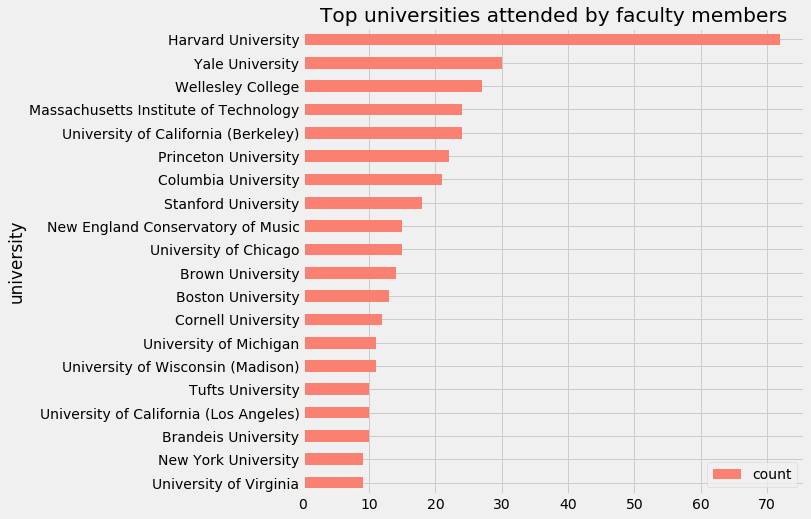

In [376]:
plotInfo(topUnis, 'Top universities attended by faculty members','university')

### 2.4 Cleaning and visualizing degree data
There are multiple labels used to describe the same degree. For example B.A. and A.B. are the same thing, but show up as two different degrees. However, since we want to count them as the same degree we go through all degrees and rename them to have a uniform naming convention.

In [377]:
def cleanDegrees(degreeList):
    """
    given a list of degrees renames degrees that are equivalent and returns a list of cleaned degrees
    """
    degreesCleaned = []
    arts_bachelor = ['B.A.', 'A.B.', ]
    music_bachelor = ['B.M.', 'B.Mus.']
    science_bachelor = ['B.S.','Sc.B.']
    arts_master = ['M.A.','A.M.']
    music_master = ['M.M.','M.Mus.']
    science_master = ['M.Sc.','M.S.']
    edu_master = ['M.Ed.','Ed.M.']
    phd = ['Ph.D.','Ph.D']
    mfa = ['MFA.','M.F.A.']
    for degree in degreeList:
        if degree in arts_bachelor:
            degreesCleaned.append('B.A.')
        elif degree in music_bachelor:
            degreesCleaned.append('B.M.')
        elif degree in science_bachelor:
            degreesCleaned.append('B.S.')
        elif degree in arts_master:
            degreesCleaned.append('M.A.')
        elif degree in music_master:
            degreesCleaned.append('M.M.')
        elif degree in science_master:
            degreesCleaned.append('M.S.')
        elif degree in edu_master:
            degreesCleaned.append('M.Ed.')
        elif degree in phd:
            degreesCleaned.append('Ph.D.')
        elif degree in mfa:
            degreesCleaned.append('M.F.A.')
        else:
            degreesCleaned.append(degree)
    return degreesCleaned

In [378]:
# example of degrees before cleaning
prof_df['degrees'][106]

['A.M.', 'Ph.D.']

In [379]:
# example of degrees after cleaning
cleanDegrees(prof_df['degrees'][106])

['M.A.', 'Ph.D.']

In [380]:
# clean degree names
prof_df['degrees_cleaned'] = prof_df['degrees'].apply(cleanDegrees)

In [381]:
# create list of all degrees
degrees_list = list(prof_df['degrees_cleaned'])
flat_degrees_list = [item for sublist in degrees_list for item in sublist]

In [382]:
# create counter with all degrees
degree_counter = Counter(flat_degrees_list)

In [385]:
degree_df = pd.DataFrame(degree_counter.most_common(), columns=['degree', 'count'])
degree_df

,degree,count
0,B.A.,323
1,Ph.D.,312
2,M.A.,210
3,B.S.,71
4,M.S.,65
5,M.M.,29
6,M.Phil.,23
7,B.M.,23
8,M.Ed.,17
9,M.F.A.,14


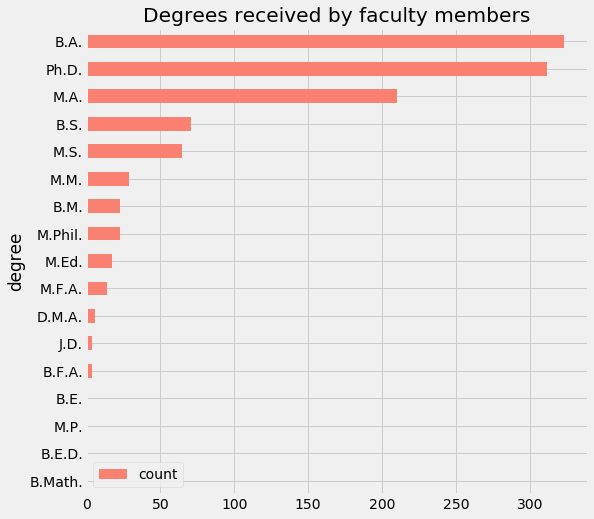

In [386]:
# plotting degrees received by faculty
plotInfo(degree_df, 'Degrees received by faculty members','degree')

From the plot above we can see that a lot of faculty members obtained a B.A. and a M.A. instead of a B.S. or M.S.
However we are also interested in the overall number of individuals receiving a bachelors, masters and phd. 

In [387]:
def degreeOverview(degreeCounts):
    """
    groups degrees by level, ie undegraduate and graduate and returns a dataframe with their counts
    """
    b_tot = 0
    m_tot = 0
    p_tot = 0
    for degree in degreeCounts.keys():
        if degree in bachelor:
            b_tot += degreeCounts[degree]
        elif degree in masters:
            m_tot += degreeCounts[degree]
        else:
            p_tot += degreeCounts[degree]
    degree_all = pd.DataFrame(['bachelor', 'master', 'phd'],columns = ['degree'])
    degree_all['count'] = [b_tot, m_tot, p_tot]
    return degree_all

In [388]:
# create degree dataframe 
degree_all_df = degreeOverview(degree_counter)
degree_all_df

,degree,count
0,bachelor,424
1,master,359
2,phd,322


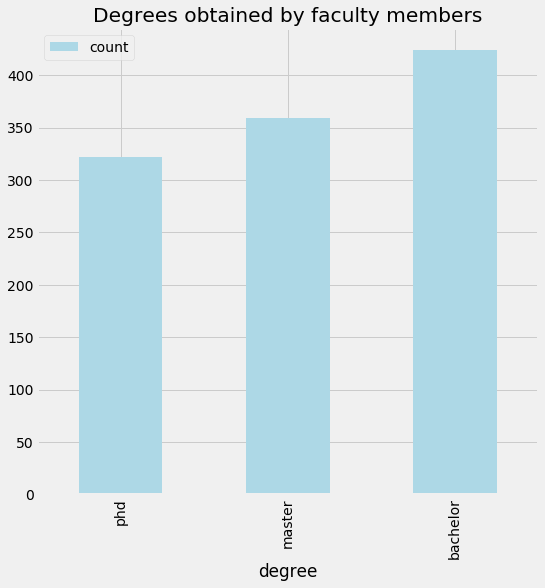

In [389]:
plotInfo(degree_all_df,"Degrees obtained by faculty members", 'degree', 'lightblue', False)

## 3. Extracting department information 
After having analyzed the degrees faculty members obtain, we are also interested in exploring the departments they work for and their levels, i.e Associate Professor or Assistant Professor. 
The first step in this process involves extracting the department and title of employment for each faculty member. 
Since faculty members may have multiple titles we go through each title column to search for their faculty description.

In [730]:
def extractTitle(title): 
    """
    given the title of a faculty member extracts their department and official title
    """
    if type(title) != float:
        if ('Performance Faculty' in title) or ('Accompanist/Coach' in title) or ('Music Instructor' in title):
            split_title = title.split(' in ')
            return split_title[0].strip(), 'Music' # clean music instructors
        
        elif ('Instructor in Physical Education' in title):
            split_title = title.split(' in ')
            return split_title[0].strip(), 'Physical Education'
        
        elif (("Lecturer in" in title) or ('Instructor in' in title) 
            or ('Professor in' in title) or ('Fellow in' in title)): 
            # skip this title if any of these keywords appear
            if (("History of Ideas" in title) or ('Critical Thought' in title) or ('the Health Sciences' in title)
             or ('Physical and Natural Sciences' in title) or ("Social Sciences" in title) or ("Humanities" in title)):
                return
            split_title = title.split(' in ')
            return split_title[0].strip(), split_title[-1].strip()
       
        elif 'PERA' in title:  # extract PE coaches
            split_title = title.split(' of ')
            return split_title[0].strip(), 'Physical Education'
        elif "Professor of" in title:
            split_title = title.split(' of ')
            if "Class of" in title: # special case for professors who have 
                return 'Class of ' + split_title[1].strip(), split_title[-1].strip()
            elif ("Social Sciences" in title) or ("Critical Thought" in title) or ("Humanities" in title): 
                return
            else:
                return split_title[0].strip(), split_title[-1].strip()
        elif (('Coach/Collaborative Keyboardist' in title) or ('Conductor' in title)):
            return title,'Music'

In [731]:
def getTitle(person, titles):
    """
    given a person's information extracts their department and title, if not found returns nothing 
    """
    for title in titles:
        if extractTitle(person[title]) != None:
            return extractTitle(person[title])
    # if nothing found print it
    print(person['name'], person['title'], 'no title found')

In [732]:
# example of getTitle function
getTitle(prof_df.iloc[4], ['title', 'title2', 'title3'])

('Senior Music Performance Faculty', 'Music')

In [733]:
# get titles of professors
prof_titles = prof_df.apply(lambda x: getTitle(x, ['title', 'title2', 'title3']), axis = 1)

Angelini, Margaret Director, Guild of Carillonneurs no title found
Ellis, Bethany Director of Athletics and Chair of Department of Physical Education, Recreation and Athletics no title found
Szegedi, Zsuzanna nan no title found
Tanriverdi, Serhan Freedom Project Postdoctoral Fellow no title found
Taodzera, Shingirai Freedom Project Postdoctoral Fellow no title found
Towlun, David Theatre Production Manager no title found


In [734]:
def getItem(titles, index):
    if titles != None:
        return titles[index]
    return ''

In [735]:
# save title and dept in dataframe columns
prof_df['role'] = prof_titles.apply(lambda x: getItem(x,0))
prof_df['dept'] = prof_titles.apply(lambda x: getItem(x,1))

Having now created extra columns that hold the role and department a faculty member is part of, there is still some cleaning left to do. For example, some professors hold a special professorship name, or are instructors or lecturers.
Thus, we first examine the different types of labels and clean these to end up with a more homogenous dataset.

In [736]:
# different titles professors hold
prof_df['role'].unique()

array(['Senior Lecturer', 'Assistant Professor',
       'Senior Music Performance Faculty', 'Professor', 'Lecturer', '',
       'Associate Professor', 'Visiting Lecturer',
       'Freedom Project Postdoctoral Fellow', 'Senior Instructor',
       'Allene Lummis Russell Professor',
       'Theodora L. and Stanley H. Feldberg Professor',
       'Catherine Mills Davis Professor', 'Frost Professor', 'Instructor',
       'Gordon P. Lang and Althea P. Lang ‘26 Professor',
       'Ralph Emerson and Alice Freeman Palmer Professor',
       'Marshall I. Goldman Professor', 'Mary Jewett Gaiser Professor',
       'Mellon Postdoctoral Fellow', 'Lorraine C. Wang Professor',
       'Andrew W. Mellon Assistant Professor',
       'Coach/Collaborative Keyboardist', 'Knafel Assistant Professor',
       'Camilla Chandler Frost Professor', 'Music Performance Faculty',
       'Theresa Mall Mullarkey Associate Professor',
       'PERA Associate Professor', 'Class of 1966 Associate Professor',
       'Phyllis 

In [737]:
def cleanProfessorTitle(title):
    """
    given the title of a professor, cleans it to 
    """
    if "Assistant Professor" in title:
        return "Assistant Professor"
    elif "Associate Professor" in title:
        return "Associate Professor"
    elif "PERA" in title:
        return title
    elif "Fellow" in title:
        return "Postdoctoral Fellow"
    elif "Visiting Lecturer" in title:
        return "Visiting Lecturer"
    elif "Professor" in title:
        return "Professor"
    elif "Senior Lecturer" in title:
        return "Senior Lecturer"
    elif (("Coach/Collaborative Keyboardist" in title) or ('Music Instructor' in title) or
          ("Accompanist" in title) or ("Conductor" in title)): # clean music faculty descriptions
        return "Music Performance Faculty"
    else:
        return title

In [738]:
# unique roles after cleaning
prof_df['role'].apply(cleanProfessorTitle).unique()

array(['Senior Lecturer', 'Assistant Professor',
       'Senior Music Performance Faculty', 'Professor', 'Lecturer', '',
       'Associate Professor', 'Visiting Lecturer', 'Postdoctoral Fellow',
       'Senior Instructor', 'Instructor', 'Music Performance Faculty',
       'PERA Professor'], dtype=object)

In [739]:
# save cleaned faculty titles in new column
prof_df['role_cleaned']= prof_df['role'].apply(cleanProfessorTitle)

After having cleaned the roles/titles faculty members hold, a similar process can be followed for cleaning the different departments they belong to. First we take a look at all the departments that are currently listed for faculty and then we can rename those that are equivalent such as Physics and Physics Laboratory (both are Physics). 

In [740]:
# unique departments in our dataset 
prof_df['dept'].unique()

array(['Middle Eastern Studies', 'Economics', 'Music', 'Spanish',
       'Psychology', 'Computer Science', '', 'Theatre Studies',
       'Writing and Anthropology', 'Political Science', 'Chemistry',
       'Religion', 'Engineering', 'Italian Studies',
       'the Writing Program', 'Physics', 'Neuroscience', 'Art',
       'Biological Sciences Laboratory', 'English', 'French',
       'Biological Sciences', 'Environmental Science',
       'Physical Education', 'Education', 'Mathematics',
       'Classical Studies', 'Cognitive and Linguistic Sciences',
       'Africana Studies', 'Geosciences', 'Women’s and Gender Studies',
       'Jewish Studies', 'Chinese', 'American Studies',
       'the Quantitative Reasoning Program', 'Economic',
       'Peace and Justice Studies', 'Sociology', 'Natural Sciences',
       'Philosophy', 'South Asia Studies', 'Environmental Studies',
       'Chemistry Laboratory', 'Anthropology', 'Russian', 'Astrophysics',
       'American Art', 'German Studies', 'History

In [745]:
def cleanDepartments(dept):
    """
    given the name of a department returns a cleaned version of the department name
    """
    
    if "Computer Science" in dept: 
        return "Computer Science"
    elif "Physics" in dept:
        return "Physics"
    elif "Chemistry" in dept:
        return "Chemistry"
    elif "Neuroscience" in dept:
        return "Neuroscience"
    elif ("Women's" in dept) or ("Women’s" in dept) or ("Health" in dept):
        return "WGST"
    elif "Chinese" in dept:
        return "Chinese"
    elif "Quantitative Reasoning" in dept:
        return "Mathematics"
    elif "Biological Sciences" in dept:
        return "Biological Sciences"
    elif "Geosciences" in dept:
        return "Geosciences"
    elif "Writing" in dept:
        return "Writing"
    elif "Econ" in dept:
        return "Economics"
    elif "Christian" in dept:
        return "Religion"
    elif "Astronomy" in dept:
        return "Astronomy"
    elif "Peace" in dept:
        return 'Peace & Justice Studies'
    elif "Environment" in dept: 
        return "Environmental Science"
    elif "Art" in dept:
        return "Art"
    elif "Asia" in dept:
        return "Asian Studies"
    elif "Ethics" in dept:
        return 'Philosophy'
    elif "Classic" in dept:
        return "Classical Studies"
    elif "Cognitive and Linguistic Sciences" in dept:
        return "Cognitive & Linguistic Sciences"
    else:
        return dept

Because some professors belong to multiple departments we would like to also extract the individual departments from the string containing the department name. To make saving and processing the data easier the departments are saved as a list instead of strings. 

In [747]:
# unique departments after preliminary cleaning
prof_df['dept'].apply(cleanDepartments).unique()

array(['Middle Eastern Studies', 'Economics', 'Music', 'Spanish',
       'Psychology', 'Computer Science', '', 'Theatre Studies', 'Writing',
       'Political Science', 'Chemistry', 'Religion', 'Engineering',
       'Italian Studies', 'Physics', 'Neuroscience', 'Art',
       'Biological Sciences', 'English', 'French',
       'Environmental Science', 'Physical Education', 'Education',
       'Mathematics', 'Classical Studies',
       'Cognitive & Linguistic Sciences', 'Africana Studies',
       'Geosciences', 'WGST', 'Jewish Studies', 'Chinese',
       'American Studies', 'Peace & Justice Studies', 'Sociology',
       'Natural Sciences', 'Philosophy', 'Asian Studies', 'Anthropology',
       'Russian', 'Astrophysics', 'German Studies', 'History', 'Japanese',
       'Portuguese', 'Italian Studies & English',
       'International Relations', 'Jewish Studies and English', 'Korean',
       'Latin American Studies', 'Astronomy',
       'Cinema & Media Studies and French', 'Cinema & Media Stu

In [779]:
def splitDept(dept):
    if dept != None and type(dept) != float:
        dept_split = dept.split('and')
        return [item.strip() for item in dept_split]
    return []

In [780]:
# save cleaned departments in df column
cleanedDept = prof_df['dept'].apply(cleanDepartments)
prof_df['cleaned_dept'] = cleanedDept.apply(splitDept)

## 4. Visualizing cleaned faculty data
After having cleaned the departments and titles faculty members hold we can move on to visualizing the different academic ranks faculty members hold as well as the departments they belong to. 

In [756]:
# counter for what type of rank faculty hold
prof_title_counter = Counter(prof_df['role_cleaned'])

In [759]:
rank_df = pd.DataFrame(prof_title_counter.most_common(), columns=['rank', 'count'])
rank_df

,rank,count
0,Professor,119
1,Associate Professor,80
2,Assistant Professor,47
3,Instructor,46
4,Lecturer,37
5,Visiting Lecturer,35
6,Senior Lecturer,22
7,Senior Music Performance Faculty,19
8,Music Performance Faculty,17
9,Senior Instructor,13


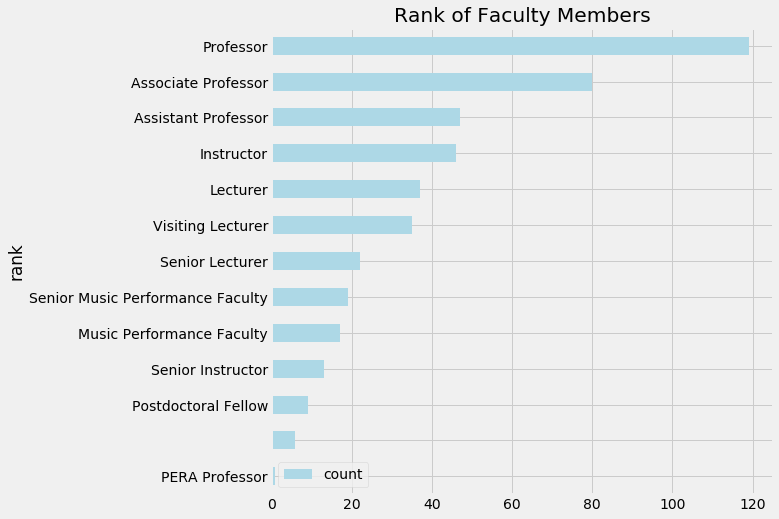

In [760]:
plotInfo(rank_df,"Rank of Faculty Members", 'rank', 'lightblue')

Again, here we see all the different ranks and number of individuals belonging to each group. But what if we are interested in the overall number of lecturers or music faculty. To examine this questions we first group faculty by their academic description ie professor, instructor etc. and then visualize the grouped data.

In [763]:
def groupRanks(rank_dict):
    """
    given a counter dictionary of ranks groups them together to different groups
    """
    # all types of faculty members
    instructor = 0
    lecturer = 0
    music = 0
    professor = 0 
    for rank in rank_dict.keys():
        if "Instructor" in rank:
            instructor += rank_dict[rank]
        elif "Professor" in rank: 
            professor += rank_dict[rank]
        elif "Music" in rank: 
            music += rank_dict[rank]
        elif "Lecturer" in rank:
            lecturer += rank_dict[rank]
    count_df = pd.DataFrame(['Instructor', 'Professor', 'Performance Faculty','Lecturer'], columns = ['title'])
    count_df['count'] = [instructor, professor, music, lecturer]
    return count_df

In [765]:
grouped_prof = groupRanks(prof_title_counter)
grouped_prof 

,title,count
0,Instructor,59
1,Professor,247
2,Performance Faculty,36
3,Lecturer,94


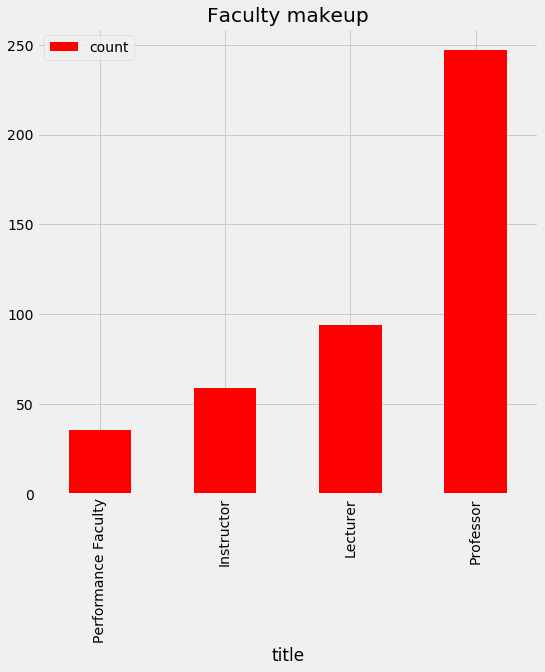

In [769]:
plotInfo(grouped_prof,"Faculty makeup", 'title', 'red', False)

Aside from the titles faculty hold we are also interested the breakdown by department. Having extracted the departments faculty members belong to we can now visualize the number of faculty per department.

In [781]:
# create list of all degrees
dept_list = list(prof_df['cleaned_dept'])
flat_dept_list = [item for sublist in dept_list for item in sublist]

In [782]:
# create counter 
dept_counter = Counter(flat_dept_list)

In [785]:
dept_df = pd.DataFrame(dept_counter.most_common(20), columns=['dept', 'count'])
dept_df.head()

,dept,count
0,Physical Education,49
1,Music,43
2,Biological Sciences,22
3,Art,21
4,Chemistry,20


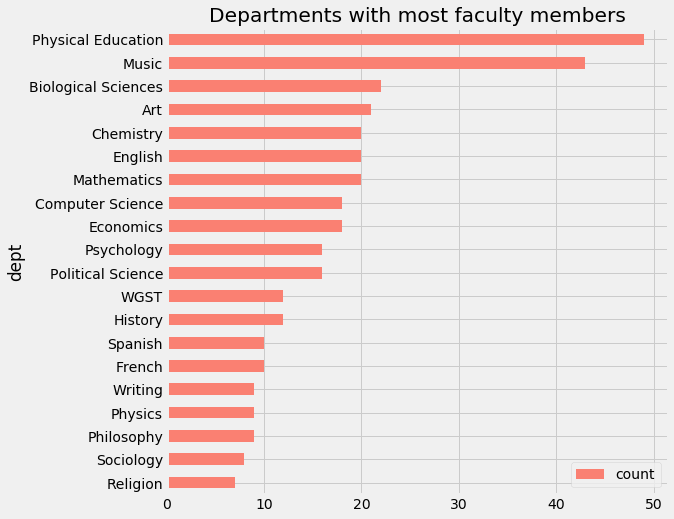

In [786]:
# plot of departments with most faculty members
plotInfo(dept_df,"Departments with most faculty members", 'dept', 'salmon')

Surprisingly enough the Physical Education department has the biggest number of coaches. The music department has the second most number of faculty members. This in turn is not so surprising as performance faculty members were also grouped under the music department and thus elevated the number of instructors in that department.

## 5. Further data exploration
Now we can take a look at particular departments and the information related to professors in that department. Let's look at the CS department first.

In [792]:
def findProfFromDept(dept, prof_info):
    """ 
    returns if a professor is part of a particular department, returns a boolean value
    """
    return dept in prof_info

In [796]:
# extract subdata frame that are CS professors at Wellesley 
CS_df = prof_df[prof_df['cleaned_dept'].apply(lambda x: findProfFromDept('Computer Science',x))]
CS_df.head()

,name,title,title2,title3,education,edu_list,edu1,edu2,edu3,edu4,colleges,degrees,colleges_clean,degrees_cleaned,role,dept,role_cleaned,cleaned_dept
7,"Anderson, Scott D.",Lecturer in Computer Science,NaN,NaN,"B.S., Yale University; M.S., Ph.D., University...","[B.S., Yale University, M.S., Ph.D., Universit...","[B.S., Yale University]","[M.S., Ph.D., University of Massachusetts (Amh...",[],[],"[Yale University, University of Massachusetts ...","[B.S., M.S., Ph.D.]","[Yale University, University of Massachusetts ...","[B.S., M.S., Ph.D.]",Lecturer,Computer Science,Lecturer,[Computer Science]
19,"Bassem, Christine",Assistant Professor of Computer Science,NaN,NaN,"B.S., Ain Shams University; M.S., German Unive...","[B.S., Ain Shams University, M.S., German Univ...","[B.S., Ain Shams University]","[M.S., German University in Cairo]","[Ph.D., Boston University]",[],"[Ain Shams University, German University in Ca...","[B.S., M.S., Ph.D.]","[Ain Shams University, German University in Ca...","[B.S., M.S., Ph.D.]",Assistant Professor,Computer Science,Assistant Professor,[Computer Science]
41,"Brubach, Brian",Assistant Professor of Computer Science,NaN,NaN,"B.A., Columbia College Chicago; B.A., Rutgers ...","[B.A., Columbia College Chicago, B.A., Rutgers...","[B.A., Columbia College Chicago]","[B.A., Rutgers University, Ph.D., University o...",[],[],"[Columbia College Chicago, Rutgers University,...","[B.A., B.A., Ph.D.]","[Columbia College Chicago, Rutgers University,...","[B.A., B.A., Ph.D.]",Assistant Professor,Computer Science,Assistant Professor,[Computer Science]
86,"Davis, Andrew",Lecturer in Computer Science,NaN,NaN,"B.A., Yale University; M.A., University of Tex...","[B.A., Yale University, M.A., University of Te...","[B.A., Yale University]","[M.A., University of Texas at Austin]","[M.S., Stanford University]","[Ph.D., University of Pennsylvania]","[Yale University, University of Texas at Austi...","[B.A., M.A., M.S., Ph.D.]","[Yale University, University of Texas at Austi...","[B.A., M.A., M.S., Ph.D.]",Lecturer,Computer Science,Lecturer,[Computer Science]
89,"Delcourt, Catherine R. A",Assistant Professor of Computer Science,NaN,NaN,"B.A., Wellesley College; M.S., Ph.D., Georgia ...","[B.A., Wellesley College, M.S., Ph.D., Georgia...","[B.A., Wellesley College]","[M.S., Ph.D., Georgia Institute of Technology]",[],[],"[Wellesley College, Georgia Institute of Techn...","[B.A., M.S., Ph.D.]","[Wellesley College, Georgia Institute of Techn...","[B.A., M.S., Ph.D.]",Assistant Professor,Computer Science,Assistant Professor,[Computer Science]


In [797]:
def getUniversities(df_col, num_colleges):
    
    # convert the colleges column to a list
    colleges_list = list(df_col)
    all_colleges_list = [item for sublist in colleges_list for item in sublist]
    
    # create counter of all colleges and their frequency 
    uni_counter = Counter(all_colleges_list)
    
    # create dataframe with most common universities
    topUnis = pd.DataFrame(uni_counter.most_common(num_colleges),
                             columns=['university', 'count'])
    return topUnis

In [801]:
# universities that CS professors attended
CS_unis = getUniversities(CS_df['colleges_clean'],20)
CS_unis

,university,count
0,University of Washington,3
1,Yale University,2
2,Stanford University,2
3,Massachusetts Institute of Technology,2
4,Amherst College,2
5,Tufts University,2
6,M.F.A. School of the Museum of Fine Arts,2
7,University of Massachusetts (Amherst),1
8,Ain Shams University,1
9,German University in Cairo,1


In [808]:
# colleges PE instructors attended
getUniversities(prof_df['colleges_clean'][prof_df['cleaned_dept'].apply(lambda x: findProfFromDept('Physical Education',x))],15)

,university,count
0,Wellesley College,3
1,Ithaca College,3
2,University of Massachusetts (Amherst),2
3,San Jose State University,1
4,University of California (Los Angeles),1
5,Boston University,1
6,Wheaton College,1
7,University of Vermont,1
8,University of Tennessee (Knoxville),1
9,Fitchburg State University,1


In [811]:
# colleges Math professors attended
getUniversities(prof_df['colleges_clean'][prof_df['cleaned_dept'].apply(lambda x: findProfFromDept('Mathematics',x))],15)

,university,count
0,Harvard University,6
1,University of Chicago,4
2,University of California (Berkeley),4
3,Massachusetts Institute of Technology,2
4,Johns Hopkins University,2
5,Brooklyn College of City University of New York,2
6,Shanghai Jiao Tong University,1
7,Michigan State University,1
8,University of Illinois,1
9,Cambridge University (England),1


In [812]:
# colleges Art professors attended
getUniversities(prof_df['colleges_clean'][prof_df['cleaned_dept'].apply(lambda x: findProfFromDept('Art',x))],15)

,university,count
0,Yale University,4
1,Wellesley College,2
2,New York University,2
3,Vassar College,2
4,Indiana University (Bloomington),2
5,Wesleyan University,2
6,Princeton University,2
7,University of Wisconsin (Madison),2
8,Maryland Institute College of Art,2
9,Hampshire College,1


In [814]:
# colleges music faculty attended
getUniversities(prof_df['colleges_clean'][prof_df['cleaned_dept'].apply(lambda x: findProfFromDept('Music',x))],10)

,university,count
0,New England Conservatory of Music,15
1,Berklee College of Music,4
2,Eastman School of Music,3
3,New England Conservatory,3
4,University of Chicago,2
5,Oberlin College,2
6,University of California (Los Angeles),2
7,Boston University,2
8,Yale University,2
9,Oberlin College and Oberlin Conservatory of Music,2


Looking through the different departments we see that the colleges faculty members attended vary by department. However, our dataset as whole is not large (451 entries) making it hard to draw conclusions if there are multiple professors in a department who are the sole individuals attending a particular institution. 


However looking at the general trend, we can see that most professors stayed on the east coast for their studies before subsequently coming to Wellesley College.

## 6. Researching Universities
Faculty members have visited multiple instutions accross the world. Some are very famous, while others are not. Nevertheless we are intererested in finding out more about these institutions, such as their locations and a bit more. 

In [832]:
# use universities package which searches a college database for information on colleges
import universities
uni = universities.API() 

In [839]:
wellesley = uni.search(name='Wellesley College')

In [840]:
for institution in wellesley:
    print(institution)

Name: Wellesley College
Country: United States
Domains:
 - wellesley.edu
Web Pages:
 - http://www.wellesley.edu/



In [841]:
# check out a different institution
exampleUni = uni.search(name='German University in Cairo')
for institution in exampleUni:
    print(institution) 

Name: German University in Cairo
Country: Egypt
Domains:
 - guc.edu.eg
Web Pages:
 - http://www.guc.edu.eg/

